# Current Issue

Batching and set frequency uploads are ideal from a privacy perspective because the server is unable to distinguish between upload patterns of two differnt mules. This gives the strongest possible privacy gaurentee. However, the problem that we have with batching and set frequency uploads is that it uploads way too much data. In short, the goodput is terrible. 

# Solution

Instead of using completely indistinguishable upload patterns, perhaps there is an intelligent way we can delay uploads so that the attacker server still does not gain any useful information. Our idea for this is to use trickle uploads which slowly upload all the data in the mule storage at once as soon as possible. This method, however, still leaks some information about how recently a mule passed a sensor. To hide this we can use delays with some randomness generated using differential privacy.   


In [24]:
# Import libraries.
import csv
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib import pyplot as plt

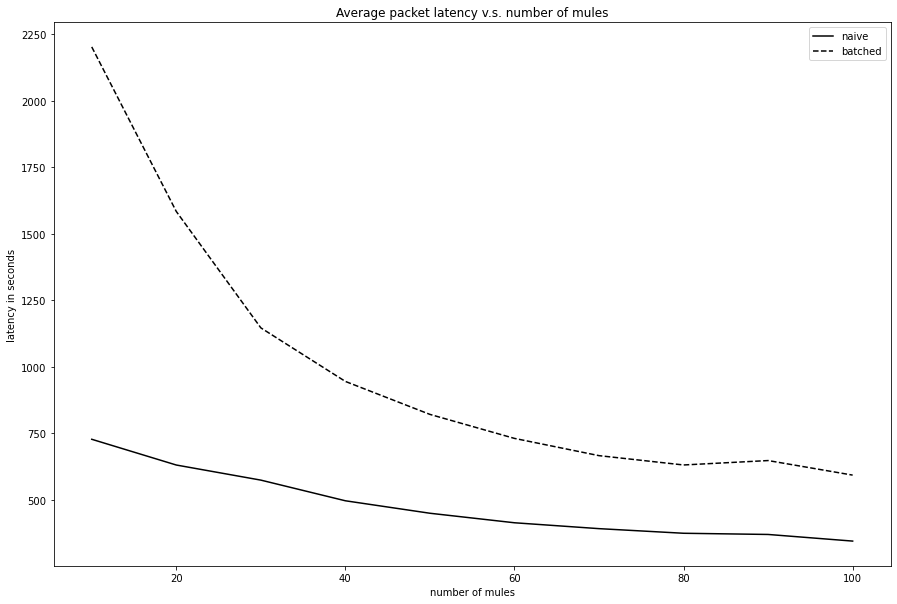

In [39]:
# generate a plot for how average latency changes over number of mules
# Copied from Alvin's latency_and_throughput_per_packet.ipynb
num_mules_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] # integer <= 100
naive_latencies = []
batch_latencies = []
dp_latencies = []
schedule_file = '../probabilistic_routing/prob_data/random_uploads/vary_mules/{}_mule_schedule.csv'

#Differential Privacy variables
sensitivity = 1
epsilon = 0.01
delay_mean = 60*20 #in seconds

for index, num_mules in enumerate(num_mules_list):
    schedule_df = pd.read_csv(schedule_file.format(num_mules), skiprows=3)
    schedule_df['naive_latency'] = schedule_df['pickup_time'] - schedule_df['sample_time']
    schedule_df['batch_latency'] = schedule_df['batch_time'] - schedule_df['sample_time']
    schedule_df['dp_latency'] = schedule_df['pickup_time'] - schedule_df['sample_time'] + np.random.laplace(loc=delay_mean, scale=sensitivity/epsilon)

    naive_latencies.append(schedule_df['naive_latency'].mean())
    batch_latencies.append(schedule_df['batch_latency'].mean())
    dp_latencies.append(schedule_df['dp_latency'].mean()) #why the mean???

plt.figure(figsize=(15,10))
plt.plot(num_mules_list, naive_latencies, 'k-', label='naive')
plt.plot(num_mules_list, batch_latencies, 'k--', label='batched')
#plt.plot(num_mules_list, dp_latencies, 'k--',label = 'dp')
plt.legend()
plt.title('Average packet latency v.s. number of mules')
plt.ylabel('latency in seconds')
plt.xlabel('number of mules')
plt.show()

## Differential Privacy Background
### (Adapted from UW ECE595 Lab 3)

*Differential privacy* is a formal notion of privacy. Differential privacy is a property of *algorithms*, and not a property of *data*. That is, we can prove that an *algorithm* satisfies differential privacy; to show that a *dataset* satisfies differential privacy, we must show that the algorithm which produced it satisfies differential privacy.

A function which satisfies differential privacy is often called a *mechanism*. We say that a *mechanism* $F$ satisfies differential privacy if for all *neighboring datasets* $x$ and $x'$, and all possible outputs $S$,

\begin{align}
\frac{\mathsf{Pr}[F(x) = S]}{\mathsf{Pr}[F(x') = S]} \leq e^\epsilon
\end{align}

The $\epsilon$ parameter in the definition is called the *privacy parameter* or the *privacy budget*. $\epsilon$ provides a knob to tune the "amount of privacy" the definition provides. Small values of $\epsilon$ require $F$ to provide *very* similar outputs when given similar inputs, and therefore provide higher levels of privacy; large values of $\epsilon$ allow less similarity in the outputs, and therefore provide less privacy. 

The general consensus is that $\epsilon$ should be around 1 or smaller, and values of $\epsilon$ above 10 probably don't do much to protect privacy - but this rule of thumb could turn out to be very conservative. 

According to the Laplace mechanism, for a function $f(x)$ which returns a number, the following definition of $F(x)$ satisfies $\epsilon$-differential privacy:

\begin{align}
F(x) = f(x) + \textsf{Lap}(\frac{s}{\epsilon})
\end{align}

where $s$ is the *sensitivity* of $f$, and $\textsf{Lap}(S)$ denotes sampling from the Laplace distribution with center 0 and scale $S$.

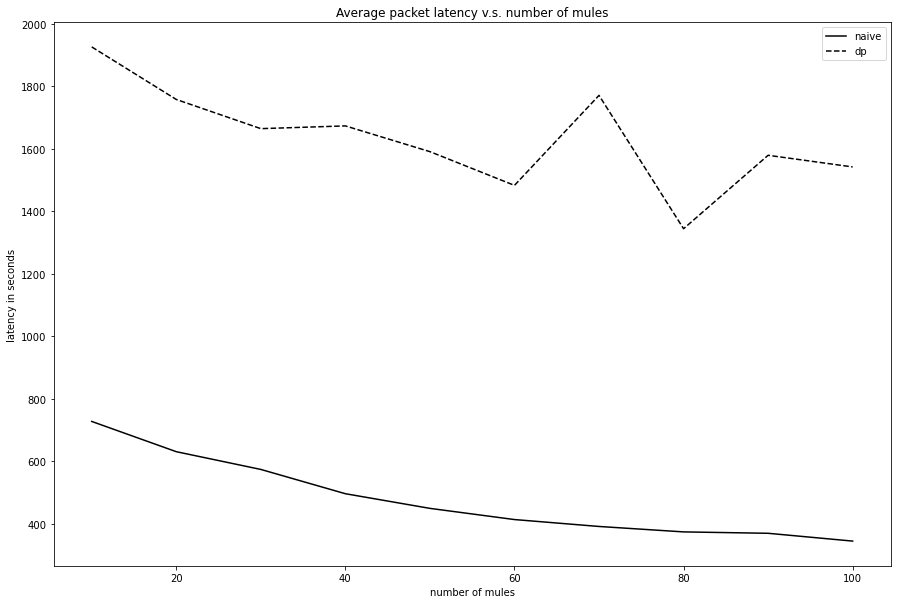

In [40]:
plt.figure(figsize=(15,10))
plt.plot(num_mules_list, naive_latencies, 'k-', label='naive')
#plt.plot(num_mules_list, batch_latencies, 'k--', label='batched')
plt.plot(num_mules_list, dp_latencies, 'k--',label = 'dp')
plt.legend()
plt.title('Average packet latency v.s. number of mules')
plt.ylabel('latency in seconds')
plt.xlabel('number of mules')
plt.show()